In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions.normal as normal
import torch.optim as optim
import matplotlib.pyplot as plt

#### NN

In [23]:
class NN(nn.Module):
    def __init__(self) -> None:
        super(NN, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, t):
        t = F.tanh(self.fc1(t))
        t = F.sigmoid(self.fc2(t))
        return t

    def predict(self, t):
        with torch.no_grad():
            t = self.forward(t)
        return t

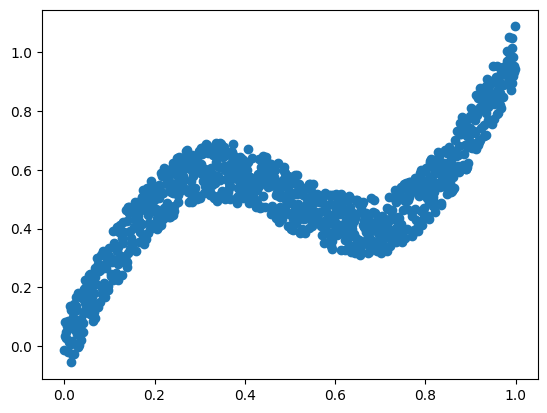

In [34]:
# x = t + 0.3 sin(2 * pi * t) + e
n = 1000
t = torch.arange(0, 1, 1/n)
e = 0.2 * torch.rand(n) - 0.1

x = t + 0.3 * torch.sin(2 * torch.pi * t) + e

plt.scatter(t, x)
plt.show()
plt.xlabel("t")
plt.ylabel("x")

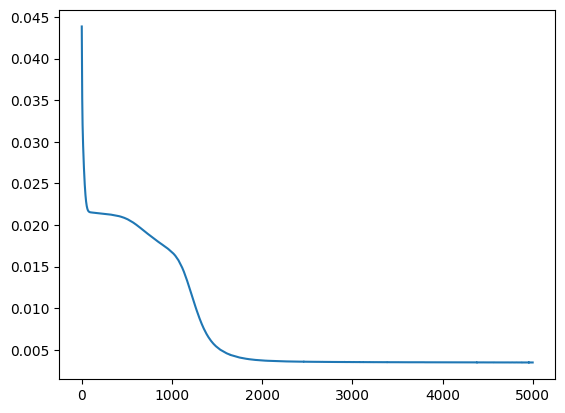

In [56]:
net = NN()
net.train()

optimizer = optim.Adam(net.parameters(), lr=0.001)
batch_size = 256
to_plot = []

for _ in range(5000):
    perm_idx = torch.randperm(len(x))
    t = t[perm_idx]
    x = x[perm_idx]

    for i in range(1000 // batch_size + 1):
        optimizer.zero_grad()

        inp = t[i * batch_size : (i + 1) * batch_size].view(-1, 1)
        target = x[i * batch_size : (i + 1) * batch_size]

        out = net.forward(inp)
        loss = torch.sum((target.view(-1) - out.view(-1)) ** 2) / target.shape[0]
        loss.backward()
        optimizer.step()

    to_plot.append(
        torch.sum((x.view(-1) - net.predict(t.view(-1, 1)).view(-1)) ** 2)
    .detach().numpy() / 1000)

plt.plot(to_plot)

Text(0, 0.5, 't')

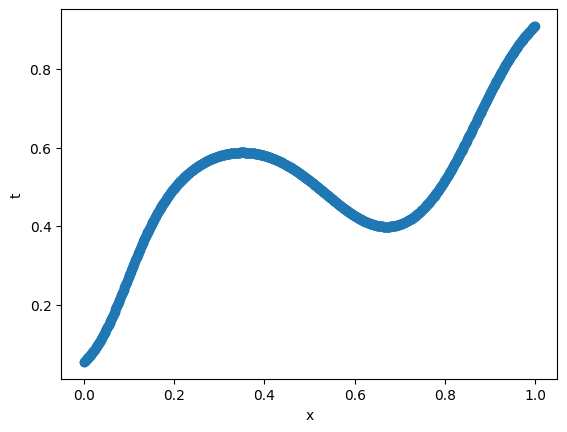

In [57]:
plt.scatter(t, net.predict(t.view(-1, 1)).detach().numpy())
plt.xlabel("x")
plt.ylabel("t")

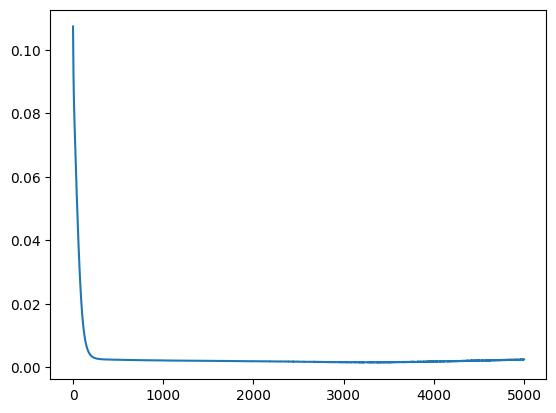

In [58]:
inv_net = NN()
inv_net.train()

optimizer = optim.Adam(inv_net.parameters(), lr=0.001)
batch_size = 256
to_plot = []

for _ in range(5000):
    perm_idx = torch.randperm(len(x))
    t = t[perm_idx]
    x = x[perm_idx]

    for i in range(1000 // batch_size + 1):
        optimizer.zero_grad()

        inp = x[i * batch_size : (i + 1) * batch_size].view(-1, 1)
        target = t[i * batch_size : (i + 1) * batch_size]

        out = inv_net.forward(inp)
        loss = torch.sum((target.view(-1) - out.view(-1)) ** 2) / target.shape[0]
        loss.backward()
        optimizer.step()

    to_plot.append(
        torch.sum((t.view(-1) - inv_net.predict(t.view(-1, 1)).view(-1)) ** 2)
    .detach().numpy() / 1000)

plt.plot(to_plot)

Text(0, 0.5, 't')

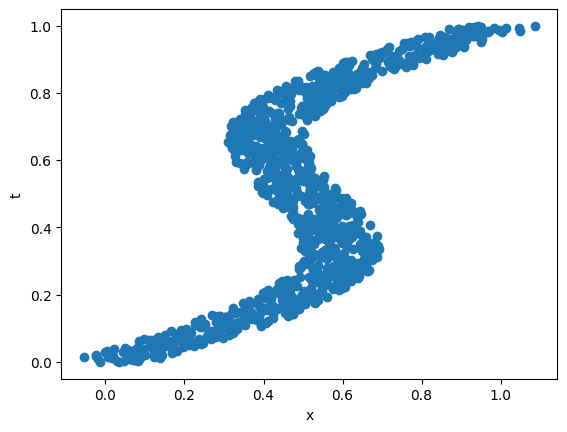

In [61]:
plt.scatter(x, t)
plt.xlabel("x")
plt.ylabel("t")

Text(0, 0.5, 't')

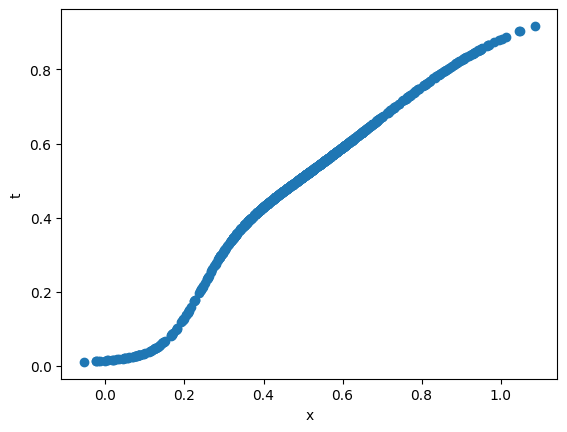

In [62]:
plt.scatter(x, inv_net.predict(x.view(-1, 1)).detach().numpy())
plt.xlabel("x")
plt.ylabel("t")

#### MDN

Text(0, 0.5, 'x')

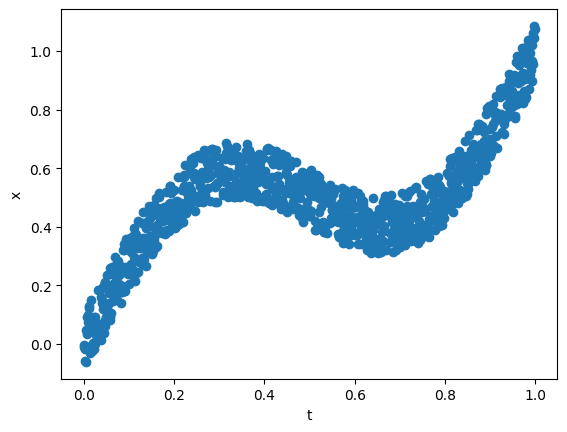

In [65]:
# x = t + 0.3 sin(2 * pi * t) + e
n = 1000
t = torch.arange(0, 1, 1/n)
e = 0.2 * torch.rand(n) - 0.1

x = t + 0.3 * torch.sin(2 * torch.pi * t) + e

plt.scatter(t, x)
plt.xlabel("t")
plt.ylabel("x")

In [156]:
class MDN(nn.Module):
    def __init__(self) -> None:
        super(MDN, self).__init__()
        self.in_features = 1
        self.out_features = 9

        self.fc1 = nn.Linear(self.in_features, 20)
        self.fc2 = nn.Linear(20, self.out_features)

    def forward(self, t):
        t = F.tanh(self.fc1(t))
        t = self.fc2(t)

        pis = F.softmax(t[:, :3], dim=1)
        sigmas = torch.exp(t[:, 3:6])
        mus = t[:, 6:]

        out = torch.cat((pis, sigmas, mus), dim=1)
        return out

    def predict(self, t):
        with torch.no_grad():
            t = self.forward(t)
        return t


def calc_loss(t, out):
    pass

In [188]:
mdn = MDN()

mdn.forward(torch.tensor([10.0, 20.0]).view(-1, 1))#.view(-1)
# pis, sigmas, mus

tensor([[0.1412, 0.7037, 0.1552, 0.9108, 0.7873, 0.6718, 0.7744, 0.5319, 0.3673],
        [0.1606, 0.6847, 0.1547, 0.9935, 0.7367, 0.6770, 0.6925, 0.5871, 0.4697]],
       grad_fn=<CatBackward0>)

In [189]:
inp = torch.tensor([0.2, 0.7]).view(-1, 1)
out = mdn.forward(inp)

gaussian = normal.Normal(loc=0, scale=1)
torch.exp(gaussian.log_prob(t[:10]))

prob = 0
for i in range(3):
    pi, sigma, mu = out[:, i], out[:, i+3], out[:, i+6]
    # print(pi, sigma, mu)
    gaussian = normal.Normal(mu, sigma)
    phi = torch.exp(gaussian.log_prob(inp))
    print(phi, pi)
    prob += pi * phi

loss = torch.sum(- torch.log(prob).view(-1))
loss

tensor([[0.3914, 0.4206],
        [0.4187, 0.4927]], grad_fn=<ExpBackward0>) tensor([0.2400, 0.2213], grad_fn=<SelectBackward0>)
tensor([[0.3812, 0.3815],
        [0.3449, 0.3480]], grad_fn=<ExpBackward0>) tensor([0.4213, 0.5100], grad_fn=<SelectBackward0>)
tensor([[0.4189, 0.4634],
        [0.1959, 0.2463]], grad_fn=<ExpBackward0>) tensor([0.3387, 0.2687], grad_fn=<SelectBackward0>)


tensor(4.0179, grad_fn=<SumBackward0>)

In [ ]:
"""
input: t
output: pis, muis, sigmais

loss = -log(out prob evaled at x)
"""